# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Change directory to where this file is located
"""

%cd '/content/drive/MyDrive/MLDL1'

/content/drive/MyDrive/MLDL1


In [ ]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 2.0.1+cu118, Device: cuda


# Utils

In [ ]:
def train(model, train_loader, criterion, optimizer, scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_bar = tqdm(train_loader)
    for batch_idx, (image, label) in enumerate(tqdm_bar):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))
    if scheduler is not None:
        scheduler.step()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
def plot_history(history):
    plt.figure(figsize=(3 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_loss'], label="train_loss")
    plt.plot(history['test_loss'], label="test_loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(history['train_acc'], label="train_acc")
    plt.plot(history['test_acc'], label="test_acc")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 5, 3)
    plt.title("Learning Rate")
    plt.plot(history['lr'], label="learning rate")
    plt.xlabel("iterations")
    plt.ylabel("LR")
    plt.show()

In [ ]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            image = image.squeeze(axis=0)
            ax[i][j].imshow(image, cmap=plt.get_cmap('gray'))
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

# Load Fashion MNIST

In [ ]:
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 26421880/26421880 [00:00<00:00, 123539683.89it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5414638.61it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 64492220.33it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


100%|██████████| 5148/5148 [00:00<00:00, 19057614.29it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



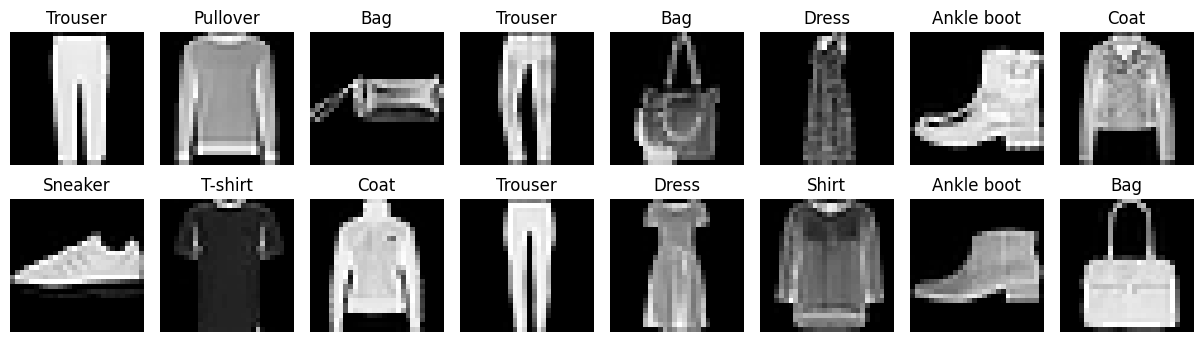

In [ ]:
plot_dataset(train_loader)

# Practice 1. Regularization

## Training without regularization

In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.0010, 	Train Loss: 0.0008, 	Train Accuracy: 70.97 %, 	Test Loss: 0.0005, 	Test Accuracy: 80.95 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 83.92 %, 	Test Loss: 0.0004, 	Test Accuracy: 84.12 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 85.73 %, 	Test Loss: 0.0004, 	Test Accuracy: 84.99 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 86.88 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.84 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 87.31 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.20 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 88.09 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.15 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 88.85 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.27 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 89.04 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.93 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 89.58 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.80 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 90.09 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.67 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 11], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 90.38 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.27 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 12], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 90.88 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.88 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 13], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 91.02 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.74 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 14], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 91.36 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.20 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 15], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 91.59 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.92 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 16], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 91.76 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.52 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 17], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.08 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.44 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 18], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.20 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.67 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 19], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.68 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.69 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 20], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.86 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.62 % 



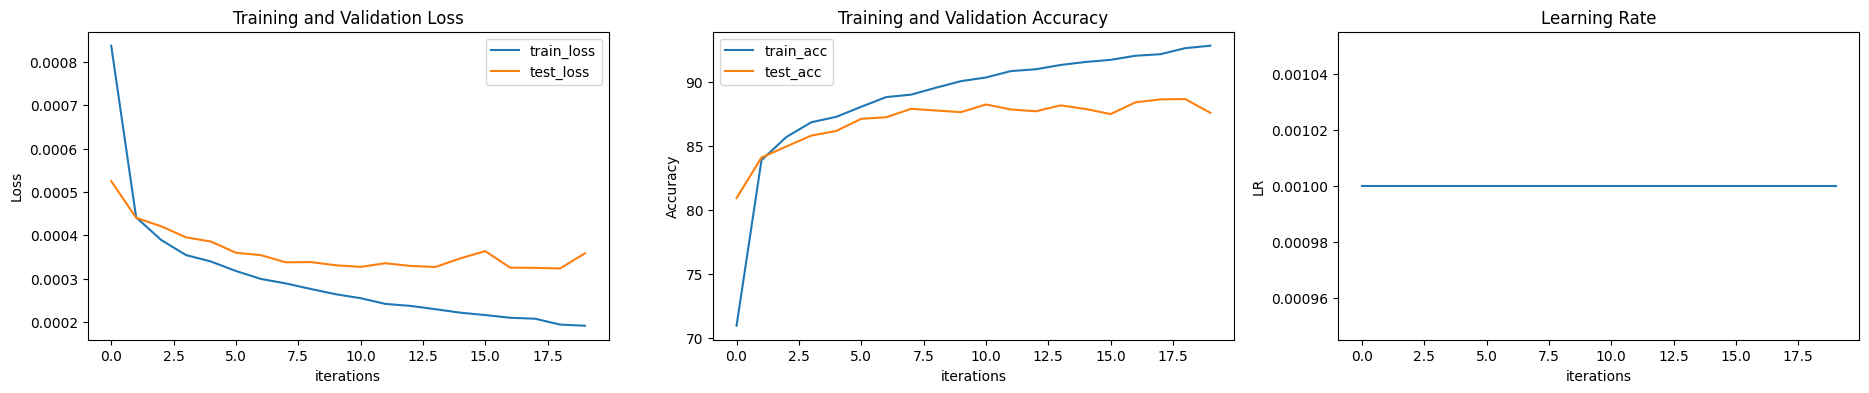

In [ ]:
EPOCHS = 20
model = SimpleClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history)

## Question1. Early Stopping

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 10),
        )

    def forward(self,x):
        x = self.conv(x)
        return x

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.0009, 	Train Loss: 0.0008, 	Train Accuracy: 72.16 %, 	Test Loss: 0.0005, 	Test Accuracy: 83.19 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.0008, 	Train Loss: 0.0004, 	Train Accuracy: 84.12 %, 	Test Loss: 0.0005, 	Test Accuracy: 85.58 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.0007, 	Train Loss: 0.0004, 	Train Accuracy: 85.48 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.70 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.0007, 	Train Loss: 0.0004, 	Train Accuracy: 86.92 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.43 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.0006, 	Train Loss: 0.0004, 	Train Accuracy: 87.44 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.95 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.0005, 	Train Loss: 0.0003, 	Train Accuracy: 87.87 %, 	Test Loss: 0.0004, 	Test Accuracy: 88.29 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.0005, 	Train Loss: 0.0003, 	Train Accuracy: 88.25 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.55 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.0004, 	Train Loss: 0.0003, 	Train Accuracy: 88.73 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.56 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.0004, 	Train Loss: 0.0003, 	Train Accuracy: 88.63 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.75 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.0003, 	Train Loss: 0.0003, 	Train Accuracy: 89.11 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.40 % 



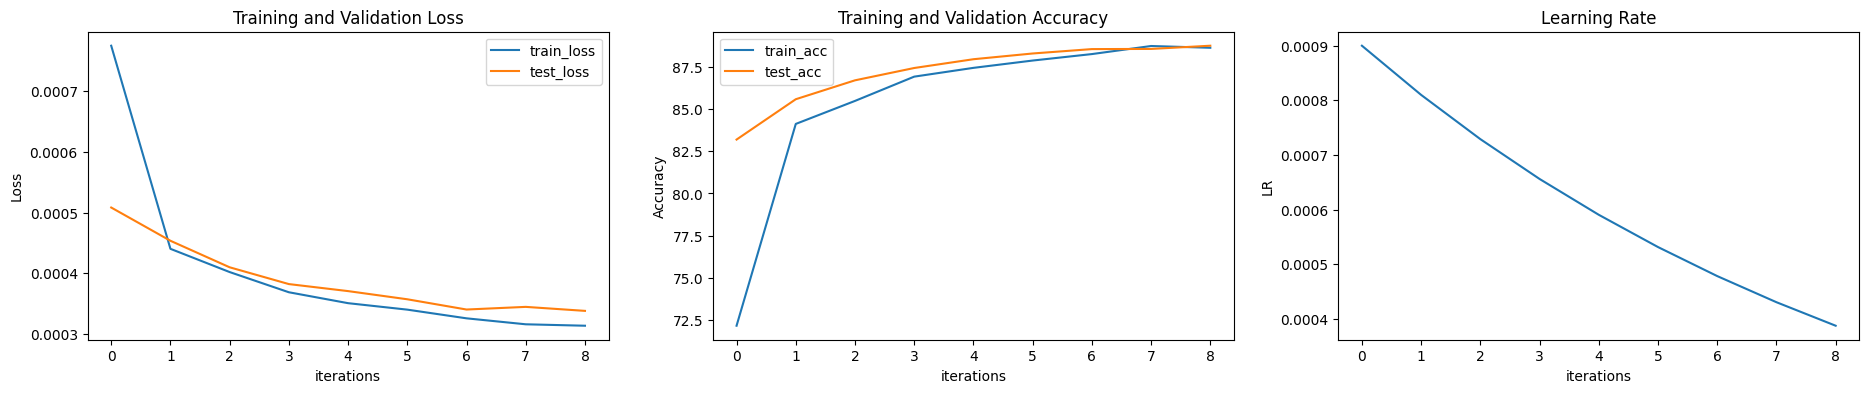

In [ ]:
"""
(1) Implement early stopping.

  - Use the variables "best_loss" and "patience".
  - If the test_loss does not improve after 2 epochs, stop the training.
"""
from torch.optim.lr_scheduler import ExponentialLR as ExponentialLR

#### Use these variables to implement early stopping ####
best_loss = 100
patience = 0
#########################################################

EPOCHS = 30
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

model = Model().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))

    ########## Your Code #########
    if test_loss < best_loss:
      best_loss = test_loss
      patience = 0
    else:
      patience += 1
    if patience >= 2:
      break
    ##############################

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history)

# Practice2. Learning Rate Scheduler

In [ ]:
"""
(1) Implement customized learning rate scheduler.
"""

class ScheduledOptim():
    def __init__(self, optimizer, n_warmup_steps, decay_rate, steps=None):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.decay = decay_rate
        self.n_steps = 0
        self.steps = steps
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.current_lr = optimizer.param_groups[0]['lr']

    def zero_grad(self):
        self._optimizer.zero_grad()

    def step(self):
        # self._optimizer.step()
        self.update()

    def get_lr(self):
        return self.current_lr

    def update(self):
        """
        Update the learning rate.

        - During the first self.n_warmup_steps, gradually increase the learning rate from 0 to the self.initial_lr.
        - Then, decay the learning rate with the given probability self.decay at each decay steps self.steps.
        - If decay steps are not given, decay the learning rate on every epoch.
        """
        ########## Your Code #########
        if self.n_steps <= self.n_warmup_steps:
          lr = self.initial_lr * (self.n_steps / self.n_warmup_steps)
        else:
          lr = self.current_lr
          if self.steps is None:
            lr *= self.decay
          else:
            if self.n_steps in self.steps:
              lr *= self.decay
        '''
        lr = None
        if self.n_steps < self.n_warmup_steps:
          lr = self.n_steps / self.n_warmup_steps * self.initial_lr
        else :
          lr = self.current_lr * self.decay
        '''
        self.current_lr = lr
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = self.current_lr

        ##############################

        self.n_steps += 1

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.00010, 	Train Loss: 0.0009, 	Train Accuracy: 69.91 %, 	Test Loss: 0.0006, 	Test Accuracy: 79.84 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.00010, 	Train Loss: 0.0005, 	Train Accuracy: 81.38 %, 	Test Loss: 0.0005, 	Test Accuracy: 83.47 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.00010, 	Train Loss: 0.0005, 	Train Accuracy: 83.80 %, 	Test Loss: 0.0005, 	Test Accuracy: 84.83 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.00010, 	Train Loss: 0.0004, 	Train Accuracy: 84.98 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.55 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.00010, 	Train Loss: 0.0004, 	Train Accuracy: 85.93 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.30 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.00010, 	Train Loss: 0.0004, 	Train Accuracy: 86.39 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.79 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.00010, 	Train Loss: 0.0004, 	Train Accuracy: 87.00 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.39 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.00010, 	Train Loss: 0.0003, 	Train Accuracy: 87.38 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.51 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.00010, 	Train Loss: 0.0003, 	Train Accuracy: 87.74 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.52 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.00010, 	Train Loss: 0.0003, 	Train Accuracy: 88.16 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.28 % 



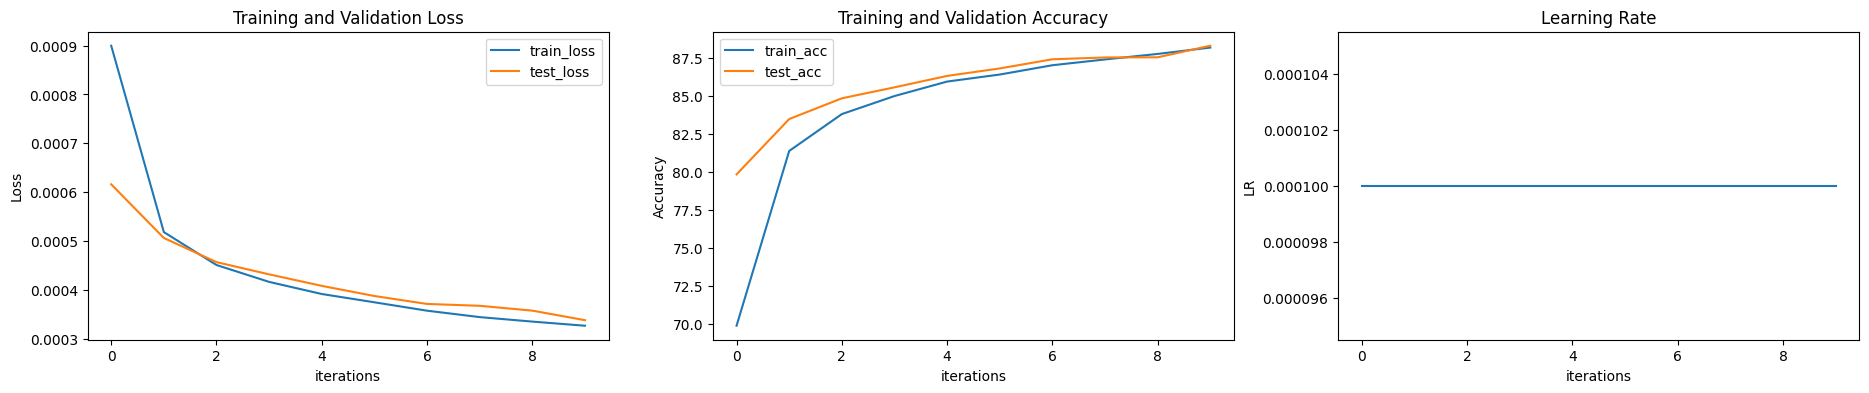

In [ ]:
EPOCHS = 10
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

scheduler = ScheduledOptim(optimizer, n_warmup_steps=3, decay_rate=0.9)
scheduler.update()

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    lr = scheduler.get_lr()
    print("\n[EPOCH: {}], \tLR: {:.5f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, lr, train_loss, train_accuracy, test_loss, test_accuracy))

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(lr)

plot_history(history)